In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO3_20_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,42.428928,42.775894,41.189766,26.334620,2698899.0,ADP,0
1,2000-01-03,47.995617,47.995617,45.515598,34.160576,6471267.0,AXP,0
2,2000-01-03,10.666667,10.812500,10.375000,6.461194,1188000.0,BEN,0
3,2000-01-03,31.687500,32.125000,30.000000,23.605961,1084800.0,CCI,0
4,2000-01-03,16.145832,16.333332,15.062500,12.189544,2333700.0,CMCSA,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
105670,2020-12-31,201.149994,203.729996,200.460007,203.550003,372200.0,LH,3
105671,2020-12-31,262.459991,263.829987,260.609985,261.461517,909300.0,LIN,3
105672,2020-12-31,174.119995,174.869995,173.179993,172.095001,1841300.0,MMM,3
105673,2020-12-31,60.520000,60.529999,59.419998,58.868961,3700400.0,NEM,3
105674,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3
105675,2020-12-31,98.660004,99.800003,98.059998,99.045059,1569300.0,PLD,3
105676,2020-12-31,73.500000,75.750000,71.199997,74.690002,6275500.0,RCL,3
105677,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3
105678,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3
105679,2020-12-31,65.750000,66.820000,65.389999,66.176384,1743300.0,XEL,3


In [8]:
df.shape

(105680, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,42.428928,42.775894,41.189766,26.334620,2698899.0,ADP,0,0.0,26.33462,26.33462,0.0,-66.666667,100.0,26.334620,26.334620,0.297174,0.260188,-0.227124
5284,2000-01-03,47.995617,47.995617,45.515598,34.160576,6471267.0,AXP,0,0.0,26.33462,26.33462,0.0,-66.666667,100.0,34.160576,34.160576,0.297174,0.260188,-0.227124
10568,2000-01-03,10.666667,10.812500,10.375000,6.461194,1188000.0,BEN,0,0.0,26.33462,26.33462,0.0,-66.666667,100.0,6.461194,6.461194,-0.810858,-1.665258,-0.227124
15852,2000-01-03,31.687500,32.125000,30.000000,23.605961,1084800.0,CCI,0,0.0,26.33462,26.33462,0.0,-66.666667,100.0,23.605961,23.605961,2.653498,1.295685,-0.227124
21136,2000-01-03,16.145832,16.333332,15.062500,12.189544,2333700.0,CMCSA,0,0.0,26.33462,26.33462,0.0,-66.666667,100.0,12.189544,12.189544,-0.483624,-0.660921,-0.227124


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(100640, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,50.161304,50.409138,48.971706,31.636026,2220123.0,ADP,1,-0.389753,33.932917,29.403171,48.139912,-33.841889,0.550341,32.562373,32.595725,1.541190,0.932632,1.685139,"[[0.0005788252744342877, 0.0001504983502951948..."
1,2001-01-02,47.703850,47.867970,45.132656,34.094334,4394265.0,AXP,1,-0.391193,37.604780,33.436031,45.492402,-76.183911,8.418778,35.468497,36.342024,0.077706,0.074835,0.773770,"[[0.0005788252744342877, 0.0001504983502951948..."
2,2001-01-02,12.666667,12.800000,12.333333,7.699205,2098500.0,BEN,1,-0.000384,8.155113,7.145027,48.954743,36.906427,2.450795,7.634939,7.856879,-0.774179,-1.488014,-0.343397,"[[0.0005788252744342877, 0.0001504983502951948..."
3,2001-01-02,27.125000,27.125000,25.000000,19.812578,416900.0,CCI,1,-0.099475,22.336516,16.853729,47.955189,23.589165,5.240388,19.653110,20.490513,1.573328,0.945200,6.201146,"[[0.0005788252744342877, 0.0001504983502951948..."
4,2001-01-02,13.645833,13.750000,13.250000,10.413256,353100.0,CMCSA,1,0.221465,10.946615,8.664207,53.860442,142.526343,20.438134,9.733164,10.022625,-0.474412,-0.643237,-0.163547,"[[0.0005788252744342877, 0.0001504983502951948..."
5,2001-01-02,34.687500,35.437500,34.312500,19.564936,982700.0,CPB,1,0.445343,19.721596,16.952097,63.370737,182.363734,40.276572,18.421300,17.233094,0.878849,0.630659,-0.381562,"[[0.0005788252744342877, 0.0001504983502951948..."
6,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.901457,-2.317265,-0.943452,"[[0.0005788252744342877, 0.0001504983502951948..."
7,2001-01-02,24.395832,25.145832,24.395832,18.741842,3312300.0,HES,1,0.809825,19.479737,13.274779,63.060917,182.263213,45.401985,16.192900,16.115218,8.720958,2.274284,1.434257,"[[0.0005788252744342877, 0.0001504983502951948..."
8,2001-01-02,67.104507,68.130394,66.347076,33.938782,2168084.0,KMB,1,0.476669,35.029619,31.123137,56.342496,100.982771,17.596253,33.153555,31.781587,0.810856,0.593800,0.712992,"[[0.0005788252744342877, 0.0001504983502951948..."
9,2001-01-02,10.125000,10.187500,9.312500,8.514878,517700.0,KSU,1,0.194955,8.799806,6.437343,48.005415,172.606604,28.285790,7.676461,7.738082,-0.749111,-1.382743,-0.182304,"[[0.0005788252744342877, 0.0001504983502951948..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,50.161304,50.409138,48.971706,31.636026,2220123.0,ADP,1,-0.389753,33.932917,29.403171,48.139912,-33.841889,0.550341,32.562373,32.595725,1.541190,0.932632,1.685139,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,47.703850,47.867970,45.132656,34.094334,4394265.0,AXP,1,-0.391193,37.604780,33.436031,45.492402,-76.183911,8.418778,35.468497,36.342024,0.077706,0.074835,0.773770,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,12.666667,12.800000,12.333333,7.699205,2098500.0,BEN,1,-0.000384,8.155113,7.145027,48.954743,36.906427,2.450795,7.634939,7.856879,-0.774179,-1.488014,-0.343397,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,27.125000,27.125000,25.000000,19.812578,416900.0,CCI,1,-0.099475,22.336516,16.853729,47.955189,23.589165,5.240388,19.653110,20.490513,1.573328,0.945200,6.201146,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,13.645833,13.750000,13.250000,10.413256,353100.0,CMCSA,1,0.221465,10.946615,8.664207,53.860442,142.526343,20.438134,9.733164,10.022625,-0.474412,-0.643237,-0.163547,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,34.687500,35.437500,34.312500,19.564936,982700.0,CPB,1,0.445343,19.721596,16.952097,63.370737,182.363734,40.276572,18.421300,17.233094,0.878849,0.630659,-0.381562,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.901457,-2.317265,-0.943452,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,24.395832,25.145832,24.395832,18.741842,3312300.0,HES,1,0.809825,19.479737,13.274779,63.060917,182.263213,45.401985,16.192900,16.115218,8.720958,2.274284,1.434257,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,67.104507,68.130394,66.347076,33.938782,2168084.0,KMB,1,0.476669,35.029619,31.123137,56.342496,100.982771,17.596253,33.153555,31.781587,0.810856,0.593800,0.712992,"[[0.0005788252744342877, 0.0001504983502951948..."
0,2001-01-02,10.125000,10.187500,9.312500,8.514878,517700.0,KSU,1,0.194955,8.799806,6.437343,48.005415,172.606604,28.285790,7.676461,7.738082,-0.749111,-1.382743,-0.182304,"[[0.0005788252744342877, 0.0001504983502951948..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,124.970001,126.790001,124.839996,126.360001,635500.0,LH,0,-8.817374,151.732354,116.697648,30.884121,-92.563035,56.449009,143.588334,155.084834,0.355841,0.304422,3.147400,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,156.229996,157.000000,153.940002,149.385696,1853900.0,LIN,0,-0.904982,155.646230,143.250467,48.868117,-29.594690,15.541690,149.513286,151.779676,0.182223,0.167397,1.610219,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,190.339996,191.649994,188.500000,174.972015,1804400.0,MMM,0,-3.012638,193.547931,164.365040,45.978354,-82.717166,15.178812,181.117179,180.870232,0.171277,0.158095,3.510324,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,34.470001,34.709999,34.119999,32.152248,4149100.0,NEM,0,0.522782,32.743812,29.796558,55.372903,114.284649,3.154492,30.930860,30.071898,-0.816243,-1.694144,-0.694801,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,135.399994,136.710007,132.259995,132.715775,11628500.0,NVDA,0,-12.202283,167.425729,120.171839,35.949703,-102.241976,36.016148,147.994607,185.317626,3.127729,1.417727,0.424039,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,58.610001,58.759998,57.570000,55.381680,2311400.0,PLD,0,-2.001768,66.316987,51.952303,40.107857,-124.235491,61.726186,60.326374,60.657615,-0.582705,-0.873961,-0.561715,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,96.589996,97.980003,96.000000,94.466072,1879200.0,RCL,0,-3.564677,111.593720,86.027541,42.010650,-103.977267,23.980401,100.999866,104.303996,0.705728,0.533992,-0.367636,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,107.570000,109.129997,106.540001,100.577728,1838000.0,SRE,0,-1.517092,111.643457,98.001803,43.179104,-144.872769,40.606737,104.600189,105.109588,0.064697,0.062690,-0.425178,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,44.099998,44.860001,44.060001,43.520153,5582300.0,TJX,0,-1.560495,47.531955,39.965531,40.623526,-53.268504,21.754848,44.689702,48.814936,-0.567298,-0.837707,0.353565,"[[0.00020524695720449052, 0.000123742113732864..."
4526,2018-12-31,49.349998,49.509998,48.730000,46.389065,4485400.0,XEL,0,-0.389237,51.353289,45.365793,47.622038,-148.523138,25.940098,48.228824,47.004343,0.065921,0.063840,-0.650463,"[[0.00020524695720449052, 0.000123742113732864..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,129.160004,130.779999,128.610001,123.853729,2190100.0,ADP,2,-3.372795,139.714576,115.202010,42.836135,-81.142726,30.757437,130.531624,132.948848,1.669891,0.982038,1.236366,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,93.910004,96.269997,93.769997,92.042946,4175400.0,AXP,2,-3.403805,109.907410,84.174485,41.204998,-97.759092,26.709417,99.719922,100.286694,-0.256842,-0.296846,-0.025651,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,29.360001,30.059999,29.209999,27.071592,2670300.0,BEN,2,-0.598739,30.760344,24.349820,46.839247,-68.971977,16.020036,28.213704,27.653331,-0.705881,-1.223770,-0.730839,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,107.620003,107.620003,105.160004,98.403236,2127700.0,CCI,2,-0.958931,110.037378,96.282712,44.808218,-117.230945,33.270661,102.813518,101.255104,2.634926,1.290589,1.261096,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,33.490002,34.450001,33.419998,32.820545,16970400.0,CMCSA,2,-0.856741,37.169594,30.886151,43.792043,-111.312327,27.902798,34.778868,34.710802,-0.666469,-1.098019,-0.292494,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,32.759998,32.880001,32.029999,29.793102,3518900.0,CPB,2,-1.411958,38.633474,29.389188,34.615048,-192.134348,61.539342,34.820498,34.897482,-0.092242,-0.096778,-0.759449,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,61.759998,64.010002,61.500000,58.045410,7839400.0,GILD,2,-1.566301,64.783223,54.769570,42.062845,-100.874673,35.123770,60.516769,62.931584,0.948284,0.666949,-0.369366,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,39.290001,42.400002,39.080002,40.460361,4692200.0,HES,2,-3.894559,56.408546,33.942007,36.033611,-112.198983,44.992828,47.530131,53.102947,-0.302953,-0.360903,0.494569,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,112.800003,113.050003,111.010002,103.360489,2634400.0,KMB,2,0.272574,109.462683,100.441128,50.326454,-51.879602,4.154170,104.473511,101.843616,1.554611,0.937900,0.050377,"[[0.0002054969310519562, 0.0001235951330070311..."
0,2019-01-02,93.959999,96.919998,93.879997,93.997391,914400.0,KSU,2,-1.431787,99.561025,88.366396,44.429699,-51.362695,9.004891,95.108894,97.833949,-0.090587,-0.094956,1.863980,"[[0.0002054969310519562, 0.0001235951330070311..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,201.149994,203.729996,200.460007,203.550003,372200.0,LH,3,0.497513,208.079822,197.391179,53.018346,27.072222,14.469995,201.632333,201.804333,-0.000159,-0.000159,3.274266,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,262.459991,263.829987,260.609985,261.461517,909300.0,LIN,3,3.287869,261.512069,242.051650,59.252406,165.301092,20.544939,251.608809,243.762066,0.284508,0.250375,3.538919,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,174.119995,174.869995,173.179993,172.095001,1841300.0,MMM,3,1.050215,174.526533,168.339208,55.439906,16.066508,7.377607,171.222333,166.996940,-0.341796,-0.418240,2.271434,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,60.520000,60.529999,59.419998,58.868961,3700400.0,NEM,3,-0.218828,60.693272,56.977499,47.895053,8.496408,7.600589,58.602453,60.223535,-0.657928,-1.072733,-0.555663,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3,-3.050796,544.860410,510.814205,49.525428,-81.517368,15.258158,528.960089,534.896957,7.867488,2.182392,1.564169,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,98.660004,99.800003,98.059998,99.045059,1569300.0,PLD,3,-0.254858,99.622921,94.489125,50.727249,37.929155,4.710228,97.553937,99.784739,-0.810266,-1.662131,-0.513412,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,73.500000,75.750000,71.199997,74.690002,6275500.0,RCL,3,-0.400646,85.282639,66.273363,53.097740,-44.642809,5.580507,76.447334,69.989167,-0.245899,-0.282229,-0.714337,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3,-0.587280,130.126919,123.147373,50.291691,-90.611282,5.294020,127.243959,127.207408,0.691363,0.525535,-0.265941,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3,1.612908,68.276751,64.593387,62.210031,103.657139,45.753201,65.137364,60.607971,-0.463404,-0.622510,0.151490,"[[0.0007890575021581794, 0.0008214604289206942..."
504,2020-12-31,65.750000,66.820000,65.389999,66.176384,1743300.0,XEL,3,-0.770737,66.353668,63.457770,47.420025,-14.933955,7.851731,65.813331,68.665470,-0.023761,-0.024047,-0.873230,"[[0.0007890575021581794, 0.0008214604289206942..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 20


In [21]:
train.tic.unique()

array(['ADP', 'AXP', 'BEN', 'CCI', 'CMCSA', 'CPB', 'GILD', 'HES', 'KMB',
       'KSU', 'LH', 'LIN', 'MMM', 'NEM', 'NVDA', 'PLD', 'RCL', 'SRE',
       'TJX', 'XEL'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_24
-------------------------------------
| time/                 |           |
|    fps                | 112       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -28.3     |
|    explained_variance | -9.54e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 8.22e+06  |
|    std                | 0.998     |
|    value_loss         | 1e+11     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -28.3    |
|    explained_variance | 5.36e-07 |
|    learning_rate      | 0.0002   |
|    n_updates        

------------------------------------
| time/                 |          |
|    fps                | 193      |
|    iterations         | 1500     |
|    time_elapsed       | 38       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 3.95e+07 |
|    std                | 0.99     |
|    value_loss         | 2.21e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 192      |
|    iterations         | 1600     |
|    time_elapsed       | 41       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -28.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 5.32e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 191      |
|    iterations         | 2900     |
|    time_elapsed       | 75       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 1.38e+07 |
|    std                | 0.983    |
|    value_loss         | 2.97e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 191      |
|    iterations         | 3000     |
|    time_elapsed       | 78       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 2.17e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 191      |
|    iterations         | 4300     |
|    time_elapsed       | 112      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -27.9    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 5.83e+07 |
|    std                | 0.976    |
|    value_loss         | 6.28e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 191       |
|    iterations         | 4400      |
|    time_elapsed       | 114       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -27.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 4399      |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 190      |
|    iterations         | 5600     |
|    time_elapsed       | 147      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -27.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 1.13e+07 |
|    std                | 0.972    |
|    value_loss         | 2.24e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 189       |
|    iterations         | 5700      |
|    time_elapsed       | 150       |
|    total_timesteps    | 28500     |
| train/                |           |
|    entropy_loss       | -27.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 5699      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 179      |
|    iterations         | 7000     |
|    time_elapsed       | 195      |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 5.39e+07 |
|    std                | 0.967    |
|    value_loss         | 5.64e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 177      |
|    iterations         | 7100     |
|    time_elapsed       | 200      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -27.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss        | 7.22e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 170      |
|    iterations         | 8300     |
|    time_elapsed       | 243      |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -27.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 1.37e+07 |
|    std                | 0.962    |
|    value_loss         | 2.81e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 170       |
|    iterations         | 8400      |
|    time_elapsed       | 245       |
|    total_timesteps    | 42000     |
| train/                |           |
|    entropy_loss       | -27.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 8399      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 174      |
|    iterations         | 9700     |
|    time_elapsed       | 278      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -27.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 5.22e+07 |
|    std                | 0.953    |
|    value_loss         | 4.12e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 174       |
|    iterations         | 9800      |
|    time_elapsed       | 281       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -27.4     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 9799      |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 176      |
|    iterations         | 11000    |
|    time_elapsed       | 312      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 1.13e+07 |
|    std                | 0.948    |
|    value_loss         | 2.14e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 176      |
|    iterations         | 11100    |
|    time_elapsed       | 314      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -27.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 1.58e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 178       |
|    iterations         | 12400     |
|    time_elapsed       | 347       |
|    total_timesteps    | 62000     |
| train/                |           |
|    entropy_loss       | -27.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 12399     |
|    policy_loss        | 4.39e+07  |
|    std                | 0.942     |
|    value_loss         | 3.59e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 178       |
|    iterations         | 12500     |
|    time_elapsed       | 349       |
|    total_timesteps    | 62500     |
| train/                |           |
|    entropy_loss       | -27.2     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 12499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 180      |
|    iterations         | 13700    |
|    time_elapsed       | 378      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -27.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 8.8e+06  |
|    std                | 0.936    |
|    value_loss         | 1.53e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 181      |
|    iterations         | 13800    |
|    time_elapsed       | 381      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -27.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss        | 1.67e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 182       |
|    iterations         | 15100     |
|    time_elapsed       | 412       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | -26.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15099     |
|    policy_loss        | 5.01e+07  |
|    std                | 0.931     |
|    value_loss         | 4.9e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 183      |
|    iterations         | 15200    |
|    time_elapsed       | 414      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -26.9    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 184      |
|    iterations         | 16400    |
|    time_elapsed       | 443      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 9.17e+06 |
|    std                | 0.926    |
|    value_loss         | 1.57e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 184      |
|    iterations         | 16500    |
|    time_elapsed       | 446      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -26.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 1.52e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 186      |
|    iterations         | 17800    |
|    time_elapsed       | 476      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -26.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 3.31e+07 |
|    std                | 0.921    |
|    value_loss         | 1.82e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 186       |
|    iterations         | 17900     |
|    time_elapsed       | 478       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17899     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 189       |
|    iterations         | 19200     |
|    time_elapsed       | 507       |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19199     |
|    policy_loss        | 1.47e+07  |
|    std                | 0.919     |
|    value_loss         | 2.74e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 189       |
|    iterations         | 19300     |
|    time_elapsed       | 509       |
|    total_timesteps    | 96500     |
| train/                |           |
|    entropy_loss       | -26.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19299     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 190      |
|    iterations         | 20600    |
|    time_elapsed       | 539      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -26.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 5.75e+07 |
|    std                | 0.91     |
|    value_loss         | 6.01e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 191      |
|    iterations         | 20700    |
|    time_elapsed       | 541      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -26.5    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 7.81e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 192      |
|    iterations         | 21900    |
|    time_elapsed       | 569      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -26.4    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 1.41e+07 |
|    std                | 0.907    |
|    value_loss         | 3.04e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 192      |
|    iterations         | 22000    |
|    time_elapsed       | 571      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -26.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 1.86e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 193       |
|    iterations         | 23300     |
|    time_elapsed       | 601       |
|    total_timesteps    | 116500    |
| train/                |           |
|    entropy_loss       | -26.3     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 23299     |
|    policy_loss        | 5.74e+07  |
|    std                | 0.903     |
|    value_loss         | 5.39e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 193      |
|    iterations         | 23400    |
|    time_elapsed       | 603      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -26.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 195      |
|    iterations         | 24600    |
|    time_elapsed       | 629      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -26.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 1.29e+07 |
|    std                | 0.898    |
|    value_loss         | 2.86e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 195      |
|    iterations         | 24700    |
|    time_elapsed       | 631      |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -26.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss        | 1.93e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 196      |
|    iterations         | 26000    |
|    time_elapsed       | 662      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -26.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 5e+07    |
|    std                | 0.892    |
|    value_loss         | 4.94e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 196      |
|    iterations         | 26100    |
|    time_elapsed       | 664      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -26.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 6.23e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 197      |
|    iterations         | 27300    |
|    time_elapsed       | 691      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -26      |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 1.44e+07 |
|    std                | 0.887    |
|    value_loss         | 2.58e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 197      |
|    iterations         | 27400    |
|    time_elapsed       | 693      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -26      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27399    |
|    policy_loss        | 2e+07    |
|

------------------------------------
| time/                 |          |
|    fps                | 197      |
|    iterations         | 28700    |
|    time_elapsed       | 728      |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -25.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28699    |
|    policy_loss        | 4.88e+07 |
|    std                | 0.882    |
|    value_loss         | 4.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 197      |
|    iterations         | 28800    |
|    time_elapsed       | 730      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -25.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss        | 6.33e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 197       |
|    iterations         | 30000     |
|    time_elapsed       | 758       |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -25.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 29999     |
|    policy_loss        | 9.97e+06  |
|    std                | 0.877     |
|    value_loss         | 1.7e+11   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 197      |
|    iterations         | 30100    |
|    time_elapsed       | 760      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -25.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 198      |
|    iterations         | 31400    |
|    time_elapsed       | 789      |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -25.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 3.96e+07 |
|    std                | 0.871    |
|    value_loss         | 3.39e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 198      |
|    iterations         | 31500    |
|    time_elapsed       | 792      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -25.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss        | 5.67e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 199      |
|    iterations         | 32700    |
|    time_elapsed       | 818      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -25.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 7.99e+06 |
|    std                | 0.867    |
|    value_loss         | 1.23e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 199       |
|    iterations         | 32800     |
|    time_elapsed       | 821       |
|    total_timesteps    | 164000    |
| train/                |           |
|    entropy_loss       | -25.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 32799     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 200       |
|    iterations         | 34100     |
|    time_elapsed       | 850       |
|    total_timesteps    | 170500    |
| train/                |           |
|    entropy_loss       | -25.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 34099     |
|    policy_loss        | 3.6e+07   |
|    std                | 0.858     |
|    value_loss         | 2.52e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 200      |
|    iterations         | 34200    |
|    time_elapsed       | 852      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -25.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 35500    |
|    time_elapsed       | 881      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -25.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 1.29e+07 |
|    std                | 0.854    |
|    value_loss         | 3.73e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 35600     |
|    time_elapsed       | 883       |
|    total_timesteps    | 178000    |
| train/                |           |
|    entropy_loss       | -25.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35599     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 202      |
|    iterations         | 36900    |
|    time_elapsed       | 912      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 4.76e+07 |
|    std                | 0.849    |
|    value_loss         | 5.05e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 202      |
|    iterations         | 37000    |
|    time_elapsed       | 915      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 6.17e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 202      |
|    iterations         | 38200    |
|    time_elapsed       | 943      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -24.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 1.33e+07 |
|    std                | 0.841    |
|    value_loss         | 3.48e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 202       |
|    iterations         | 38300     |
|    time_elapsed       | 945       |
|    total_timesteps    | 191500    |
| train/                |           |
|    entropy_loss       | -24.9     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 38299     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 203       |
|    iterations         | 39600     |
|    time_elapsed       | 975       |
|    total_timesteps    | 198000    |
| train/                |           |
|    entropy_loss       | -24.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39599     |
|    policy_loss        | 5.35e+07  |
|    std                | 0.838     |
|    value_loss         | 5.39e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 39700    |
|    time_elapsed       | 977      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -24.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 40900    |
|    time_elapsed       | 1005     |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 1.27e+07 |
|    std                | 0.831    |
|    value_loss         | 2.63e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 41000    |
|    time_elapsed       | 1007     |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 1.5e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 204       |
|    iterations         | 42300     |
|    time_elapsed       | 1036      |
|    total_timesteps    | 211500    |
| train/                |           |
|    entropy_loss       | -24.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 42299     |
|    policy_loss        | 3.7e+07   |
|    std                | 0.826     |
|    value_loss         | 3.25e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 204       |
|    iterations         | 42400     |
|    time_elapsed       | 1038      |
|    total_timesteps    | 212000    |
| train/                |           |
|    entropy_loss       | -24.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 42399     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 204      |
|    iterations         | 43600    |
|    time_elapsed       | 1066     |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 9.6e+06  |
|    std                | 0.82     |
|    value_loss         | 1.95e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 204      |
|    iterations         | 43700    |
|    time_elapsed       | 1068     |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -24.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 1.47e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 205      |
|    iterations         | 45000    |
|    time_elapsed       | 1097     |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -24.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 3.29e+07 |
|    std                | 0.815    |
|    value_loss         | 2.48e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 205       |
|    iterations         | 45100     |
|    time_elapsed       | 1099      |
|    total_timesteps    | 225500    |
| train/                |           |
|    entropy_loss       | -24.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 45099     |
|    policy_loss        | 5

------------------------------------
| time/                 |          |
|    fps                | 205      |
|    iterations         | 46300    |
|    time_elapsed       | 1127     |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 7.55e+06 |
|    std                | 0.811    |
|    value_loss         | 1.32e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 205      |
|    iterations         | 46400    |
|    time_elapsed       | 1129     |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -24.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 1.31e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 205       |
|    iterations         | 47700     |
|    time_elapsed       | 1158      |
|    total_timesteps    | 238500    |
| train/                |           |
|    entropy_loss       | -24       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47699     |
|    policy_loss        | 3.54e+07  |
|    std                | 0.806     |
|    value_loss         | 2.39e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 205       |
|    iterations         | 47800     |
|    time_elapsed       | 1160      |
|    total_timesteps    | 239000    |
| train/                |           |
|    entropy_loss       | -24       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47799     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 49000    |
|    time_elapsed       | 1188     |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -23.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 6.38e+06 |
|    std                | 0.802    |
|    value_loss         | 9.88e+10 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 49100    |
|    time_elapsed       | 1190     |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -23.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss        | 1.36e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 50400    |
|    time_elapsed       | 1220     |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 3.7e+07  |
|    std                | 0.797    |
|    value_loss         | 3.36e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 50500    |
|    time_elapsed       | 1222     |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -23.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 50499    |
|    policy_loss        | 5.72e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 206       |
|    iterations         | 51800     |
|    time_elapsed       | 1252      |
|    total_timesteps    | 259000    |
| train/                |           |
|    entropy_loss       | -23.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 51799     |
|    policy_loss        | 1.05e+07  |
|    std                | 0.79      |
|    value_loss         | 2.85e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 51900    |
|    time_elapsed       | 1254     |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -23.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 53200    |
|    time_elapsed       | 1283     |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 4.8e+07  |
|    std                | 0.787    |
|    value_loss         | 5.23e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 53300    |
|    time_elapsed       | 1285     |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -23.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 6.18e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 54500    |
|    time_elapsed       | 1313     |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -23.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 1.06e+07 |
|    std                | 0.782    |
|    value_loss         | 3.08e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 207       |
|    iterations         | 54600     |
|    time_elapsed       | 1315      |
|    total_timesteps    | 273000    |
| train/                |           |
|    entropy_loss       | -23.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54599     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 207       |
|    iterations         | 55900     |
|    time_elapsed       | 1345      |
|    total_timesteps    | 279500    |
| train/                |           |
|    entropy_loss       | -23.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 55899     |
|    policy_loss        | 4.12e+07  |
|    std                | 0.778     |
|    value_loss         | 3.65e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 207       |
|    iterations         | 56000     |
|    time_elapsed       | 1347      |
|    total_timesteps    | 280000    |
| train/                |           |
|    entropy_loss       | -23.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 55999     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 57200    |
|    time_elapsed       | 1375     |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 1.04e+07 |
|    std                | 0.771    |
|    value_loss         | 2.4e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 57300    |
|    time_elapsed       | 1377     |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -23.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss        | 1.6e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 208       |
|    iterations         | 58600     |
|    time_elapsed       | 1407      |
|    total_timesteps    | 293000    |
| train/                |           |
|    entropy_loss       | -23       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58599     |
|    policy_loss        | 4.07e+07  |
|    std                | 0.767     |
|    value_loss         | 4.16e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 208       |
|    iterations         | 58700     |
|    time_elapsed       | 1409      |
|    total_timesteps    | 293500    |
| train/                |           |
|    entropy_loss       | -23       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58699     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 59900    |
|    time_elapsed       | 1437     |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -22.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 9.54e+06 |
|    std                | 0.762    |
|    value_loss         | 2.06e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 60000    |
|    time_elapsed       | 1439     |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -22.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 1.39e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 61300    |
|    time_elapsed       | 1470     |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 3.64e+07 |
|    std                | 0.759    |
|    value_loss         | 3.06e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 61400    |
|    time_elapsed       | 1472     |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -22.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 4.43e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 62600    |
|    time_elapsed       | 1500     |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -22.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 7.57e+06 |
|    std                | 0.754    |
|    value_loss         | 1.34e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 62700    |
|    time_elapsed       | 1502     |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -22.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss        | 1.26e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 64000    |
|    time_elapsed       | 1533     |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 3.09e+07 |
|    std                | 0.748    |
|    value_loss         | 2.52e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 64100    |
|    time_elapsed       | 1535     |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -22.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss        | 4.31e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 65300    |
|    time_elapsed       | 1563     |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -22.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 6.69e+06 |
|    std                | 0.744    |
|    value_loss         | 9.21e+10 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 65400    |
|    time_elapsed       | 1565     |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -22.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 1.21e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 66700    |
|    time_elapsed       | 1596     |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 3.05e+07 |
|    std                | 0.74     |
|    value_loss         | 2.35e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 66800    |
|    time_elapsed       | 1598     |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -22.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 4.35e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 68100     |
|    time_elapsed       | 1628      |
|    total_timesteps    | 340500    |
| train/                |           |
|    entropy_loss       | -22.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68099     |
|    policy_loss        | 1.03e+07  |
|    std                | 0.736     |
|    value_loss         | 2.82e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 68200     |
|    time_elapsed       | 1630      |
|    total_timesteps    | 341000    |
| train/                |           |
|    entropy_loss       | -22.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68199     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 69500     |
|    time_elapsed       | 1661      |
|    total_timesteps    | 347500    |
| train/                |           |
|    entropy_loss       | -22       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69499     |
|    policy_loss        | 3.51e+07  |
|    std                | 0.729     |
|    value_loss         | 3.95e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 69600    |
|    time_elapsed       | 1663     |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -22      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 70800    |
|    time_elapsed       | 1690     |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -21.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 9.53e+06 |
|    std                | 0.725    |
|    value_loss         | 2.38e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 70900    |
|    time_elapsed       | 1693     |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -21.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70899    |
|    policy_loss        | 1.6e+07  |
|

-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 72200     |
|    time_elapsed       | 1723      |
|    total_timesteps    | 361000    |
| train/                |           |
|    entropy_loss       | -21.8     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 72199     |
|    policy_loss        | 3.7e+07   |
|    std                | 0.721     |
|    value_loss         | 3.41e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 72300    |
|    time_elapsed       | 1726     |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -21.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 73500     |
|    time_elapsed       | 1753      |
|    total_timesteps    | 367500    |
| train/                |           |
|    entropy_loss       | -21.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 73499     |
|    policy_loss        | 9.26e+06  |
|    std                | 0.715     |
|    value_loss         | 2.14e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 73600    |
|    time_elapsed       | 1756     |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -21.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 74900    |
|    time_elapsed       | 1786     |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 3.52e+07 |
|    std                | 0.711    |
|    value_loss         | 3.52e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 75000    |
|    time_elapsed       | 1788     |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -21.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 3.93e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 76200    |
|    time_elapsed       | 1816     |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -21.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 8.1e+06  |
|    std                | 0.705    |
|    value_loss         | 1.93e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 76300    |
|    time_elapsed       | 1818     |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -21.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 1.29e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 77600    |
|    time_elapsed       | 1849     |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 3.18e+07 |
|    std                | 0.7      |
|    value_loss         | 3.19e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 77700    |
|    time_elapsed       | 1851     |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 3.72e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 78900    |
|    time_elapsed       | 1879     |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -21.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 8.02e+06 |
|    std                | 0.698    |
|    value_loss         | 1.53e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 79000    |
|    time_elapsed       | 1881     |
|    total_timesteps    | 395000   |
| train/                |          |
|    entropy_loss       | -21.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78999    |
|    policy_loss        | 1.07e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 80300    |
|    time_elapsed       | 1912     |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -21      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 3.15e+07 |
|    std                | 0.692    |
|    value_loss         | 2.81e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 80400    |
|    time_elapsed       | 1914     |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -21      |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 4e+07    |
|

------------------------------------
| time/                 |          |
|    fps                | 210      |
|    iterations         | 81600    |
|    time_elapsed       | 1942     |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -20.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 6.42e+06 |
|    std                | 0.69     |
|    value_loss         | 1.01e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 210       |
|    iterations         | 81700     |
|    time_elapsed       | 1944      |
|    total_timesteps    | 408500    |
| train/                |           |
|    entropy_loss       | -20.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 81699     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 210      |
|    iterations         | 83000    |
|    time_elapsed       | 1974     |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -20.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 2.57e+07 |
|    std                | 0.685    |
|    value_loss         | 2.11e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 210       |
|    iterations         | 83100     |
|    time_elapsed       | 1977      |
|    total_timesteps    | 415500    |
| train/                |           |
|    entropy_loss       | -20.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 83099     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 210      |
|    iterations         | 84400    |
|    time_elapsed       | 2007     |
|    total_timesteps    | 422000   |
| train/                |          |
|    entropy_loss       | -20.6    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 84399    |
|    policy_loss        | 9.62e+06 |
|    std                | 0.681    |
|    value_loss         | 2.99e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 210       |
|    iterations         | 84500     |
|    time_elapsed       | 2010      |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -20.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84499     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 85800     |
|    time_elapsed       | 2044      |
|    total_timesteps    | 429000    |
| train/                |           |
|    entropy_loss       | -20.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 85799     |
|    policy_loss        | 4.62e+07  |
|    std                | 0.678     |
|    value_loss         | 4.74e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 85900    |
|    time_elapsed       | 2046     |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -20.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 87100    |
|    time_elapsed       | 2076     |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -20.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 8.58e+06 |
|    std                | 0.672    |
|    value_loss         | 2.01e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 87200    |
|    time_elapsed       | 2078     |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -20.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 1.22e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 88500    |
|    time_elapsed       | 2110     |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -20.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 2.73e+07 |
|    std                | 0.667    |
|    value_loss         | 3.38e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 209       |
|    iterations         | 88600     |
|    time_elapsed       | 2113      |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -20.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 89800    |
|    time_elapsed       | 2142     |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 8.46e+06 |
|    std                | 0.663    |
|    value_loss         | 2.43e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 89900    |
|    time_elapsed       | 2144     |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 89899    |
|    policy_loss        | 1.21e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 91200    |
|    time_elapsed       | 2177     |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -19.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 2.94e+07 |
|    std                | 0.658    |
|    value_loss         | 2.98e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 91300    |
|    time_elapsed       | 2179     |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -19.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 3.47e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 92500    |
|    time_elapsed       | 2209     |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -19.8    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 7.14e+06 |
|    std                | 0.655    |
|    value_loss         | 1.85e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 92600    |
|    time_elapsed       | 2212     |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -19.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 1.02e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 93900    |
|    time_elapsed       | 2245     |
|    total_timesteps    | 469500   |
| train/                |          |
|    entropy_loss       | -19.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 93899    |
|    policy_loss        | 3.04e+07 |
|    std                | 0.649    |
|    value_loss         | 3.14e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 209      |
|    iterations         | 94000    |
|    time_elapsed       | 2248     |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -19.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss        | 4.33e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 95200    |
|    time_elapsed       | 2279     |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -19.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 7.14e+06 |
|    std                | 0.644    |
|    value_loss         | 1.61e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 95300    |
|    time_elapsed       | 2281     |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -19.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss        | 1.05e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 96600    |
|    time_elapsed       | 2315     |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -19.4    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 3.03e+07 |
|    std                | 0.64     |
|    value_loss         | 2.79e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 208       |
|    iterations         | 96700     |
|    time_elapsed       | 2317      |
|    total_timesteps    | 483500    |
| train/                |           |
|    entropy_loss       | -19.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96699     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 97900    |
|    time_elapsed       | 2347     |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -19.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 6.61e+06 |
|    std                | 0.636    |
|    value_loss         | 9.68e+10 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 208       |
|    iterations         | 98000     |
|    time_elapsed       | 2349      |
|    total_timesteps    | 490000    |
| train/                |           |
|    entropy_loss       | -19.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 97999     |
|    policy_loss        | 9

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 99300    |
|    time_elapsed       | 2382     |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -19.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 2.23e+07 |
|    std                | 0.631    |
|    value_loss         | 2.15e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 99400    |
|    time_elapsed       | 2384     |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -19.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 3.23e+07 |
|

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_8
begin_total_asset:100000
end_total_asset:1163370.7384750494
Sharpe:  0.7937602093423479
begin_total_asset:100000
end_total_asset:1155142.925230597
Sharpe:  0.7884791497809754
begin_total_asset:100000
end_total_asset:1091654.2191005216
Sharpe:  0.778075492468475
begin_total_asset:100000
end_total_asset:995770.4114350064
Sharpe:  0.74728358930063
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 9.96e+05                |
|    total_reward    | [0, 0.02951365007752... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 27                      |
|    time_elapsed    | 656                     |
|    total timesteps | 18108                   |
| train/             |                    

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_8
-----------------------------
| time/              |      |
|    fps             | 240  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 242           |
|    iterations           | 2             |
|    time_elapsed         | 16            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.6391277e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0001        |
|    loss                 | 4.1e+12       |
|    n_updates            | 10         

-------------------------------------------
| time/                   |               |
|    fps                  | 235           |
|    iterations           | 10            |
|    time_elapsed         | 86            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 2.0302832e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -28.4         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 9.74e+13      |
|    n_updates            | 90            |
|    policy_gradient_loss | -1.07e-06     |
|    std                  | 1             |
|    value_loss           | 1.98e+14      |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 236            |
|    iterations           | 1

begin_total_asset:100000
end_total_asset:1002981.6811545982
Sharpe:  0.7411130015519634
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1e+06                   |
|    total_reward         | [0, 0.02952629123778... |
| time/                   |                         |
|    fps                  | 236                     |
|    iterations           | 18                      |
|    time_elapsed         | 156                     |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -6.472692e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.49e+13            

--------------------------------------------
| time/                   |                |
|    fps                  | 237            |
|    iterations           | 26             |
|    time_elapsed         | 223            |
|    total_timesteps      | 53248          |
| train/                  |                |
|    approx_kl            | -1.5553087e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -28.4          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss                 | 5.72e+13       |
|    n_updates            | 250            |
|    policy_gradient_loss | -2.26e-06      |
|    std                  | 1              |
|    value_loss           | 1.02e+14       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1197857.5232997022
Sharpe:  0.7922315812603454
-----------------------------------------------------
| e

begin_total_asset:100000
end_total_asset:1140883.064743562
Sharpe:  0.7811910087350316
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.14e+06                |
|    total_reward         | [0, 0.02228876483249... |
| time/                   |                         |
|    fps                  | 240                     |
|    iterations           | 34                      |
|    time_elapsed         | 288                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 0.0                     |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 6.16e+13             

begin_total_asset:100000
end_total_asset:940390.5485861114
Sharpe:  0.7260473491899896
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 9.4e+05                 |
|    total_reward         | [0, 0.02745172182469... |
| time/                   |                         |
|    fps                  | 241                     |
|    iterations           | 42                      |
|    time_elapsed         | 355                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 5.811453e-07            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -28.4                   |
|    explained_variance   | 1.19e-07                |
|    learning_rate        | 0.0001                  |
|    loss                 | 7.44e+12             

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(10100, 20)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:156033.05409884595
Sharpe:  0.9954963313891676
hit end!


In [32]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.012133
2,2019-01-04,0.028799
3,2019-01-07,0.007498
4,2019-01-08,0.007748


In [33]:
df_actions.head()

,ADP,AXP,BEN,CCI,CMCSA,CPB,GILD,HES,KMB,KSU,LH,LIN,MMM,NEM,NVDA,PLD,RCL,SRE,TJX,XEL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.085681,0.057478,0.085681,0.045354,0.031520,0.076767,0.031520,0.085681,0.085681,0.031520,0.040972,0.031520,0.031520,0.085681,0.031520,0.031520,0.031520,0.031520,0.031520,0.035817
2019-01-04,0.088535,0.060778,0.088535,0.042459,0.032570,0.088535,0.032570,0.032570,0.088535,0.032570,0.032570,0.032570,0.032570,0.088535,0.032570,0.032570,0.032570,0.032570,0.032570,0.063250
2019-01-07,0.048635,0.090470,0.090470,0.090470,0.033282,0.033282,0.033282,0.033282,0.090470,0.033282,0.033657,0.033282,0.033282,0.090470,0.033282,0.033282,0.033282,0.037599,0.033282,0.061652
2019-01-08,0.084216,0.030981,0.084216,0.084216,0.030981,0.084216,0.030981,0.073815,0.084216,0.030981,0.030981,0.030981,0.030981,0.084216,0.030981,0.030981,0.030981,0.049111,0.030981,0.030981


In [34]:
df_actions.to_csv('df_actions_a2c_1.csv')

In [35]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [36]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.248582
Cumulative returns      0.560331
Annual volatility       0.256203
Sharpe ratio            0.995496
Calmar ratio            0.729241
Stability               0.665183
Max drawdown           -0.340877
Omega ratio             1.234838
Sortino ratio           1.398263
Skew                   -0.449031
Kurtosis               12.228567
Tail ratio              1.023078
Daily value at risk    -0.031266
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,24.858%
Cumulative returns,56.033%
Annual volatility,25.62%
Sharpe ratio,1.00
Calmar ratio,0.73
Stability,0.67
Max drawdown,-34.088%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.09,2020-02-20,2020-03-23,2020-08-06,121
1,8.64,2020-09-02,2020-09-23,2020-11-09,49
2,5.00,2019-07-15,2019-08-05,2019-09-05,39
3,4.36,2019-04-12,2019-05-31,2019-06-06,40
4,3.50,2019-09-17,2019-10-02,2019-10-17,23


Stress Events,mean,min,max
New Normal,0.10%,-9.80%,10.54%


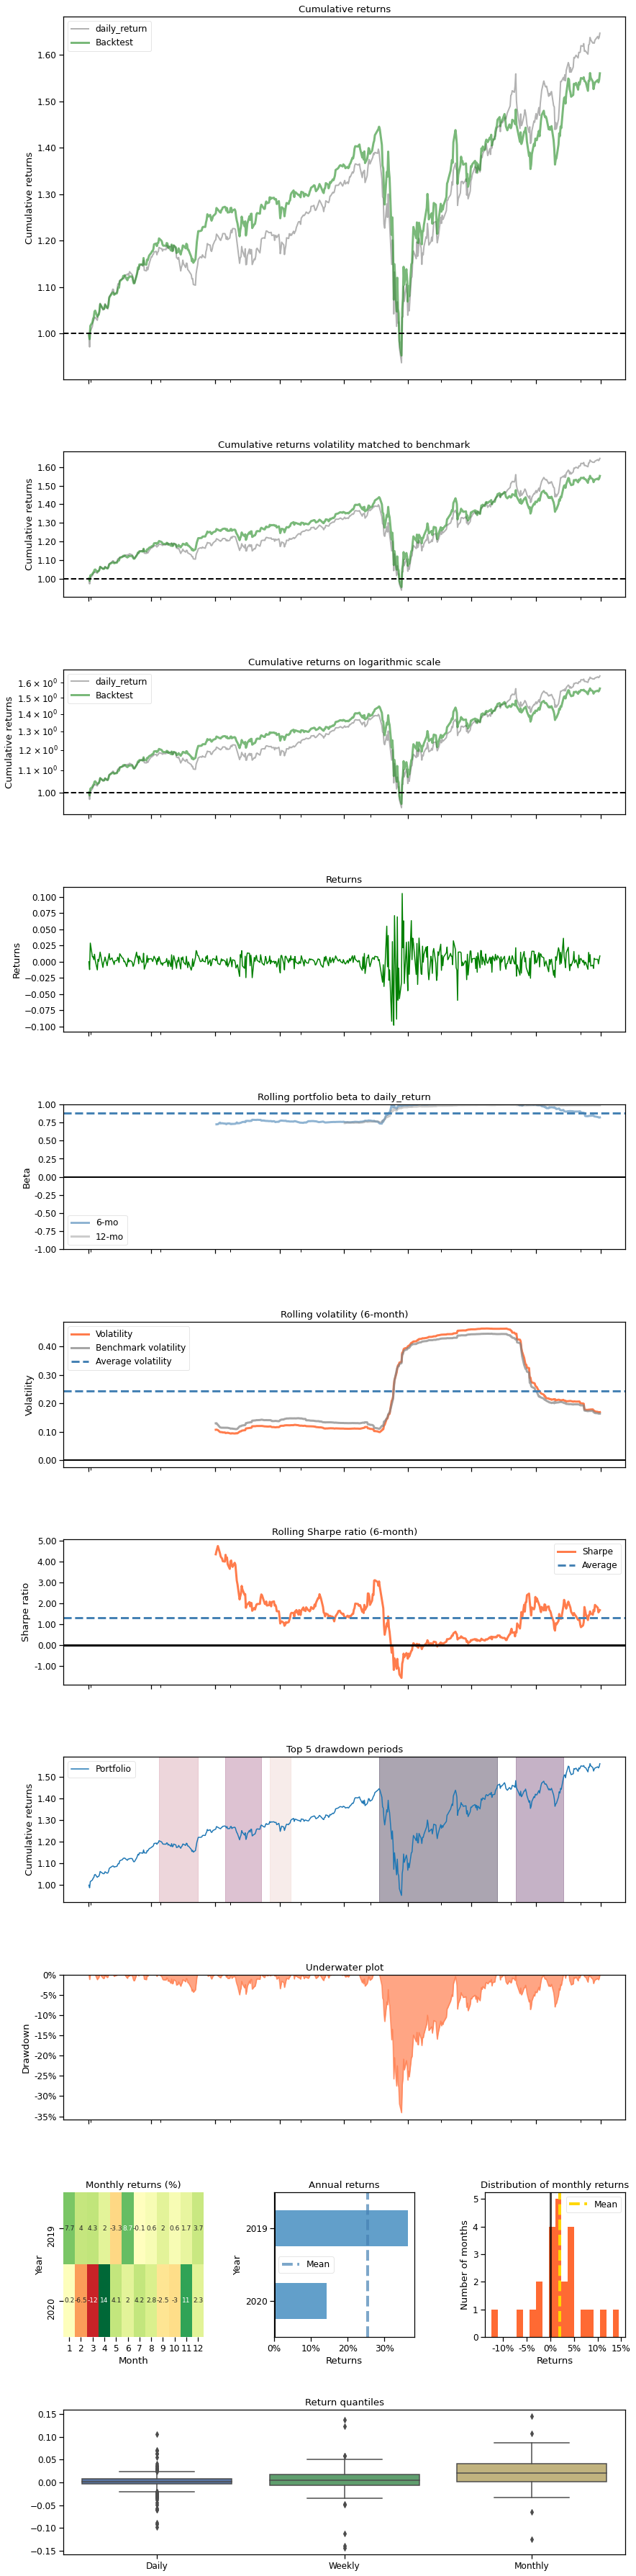

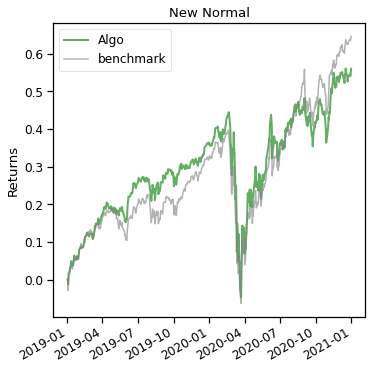

In [38]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [39]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:158119.91679004286
Sharpe:  0.980419489957002
hit end!


In [40]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.014803
2,2019-01-04,0.031731
3,2019-01-07,0.010193
4,2019-01-08,0.005796
...,...,...
500,2020-12-24,0.002767
501,2020-12-28,0.005363
502,2020-12-29,-0.004063
503,2020-12-30,0.005627


In [41]:
df_actions.head()

,ADP,AXP,BEN,CCI,CMCSA,CPB,GILD,HES,KMB,KSU,LH,LIN,MMM,NEM,NVDA,PLD,RCL,SRE,TJX,XEL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.056822,0.082627,0.036166,0.036166,0.036166,0.036166,0.043556,0.036166,0.036166,0.088716,0.036166,0.036166,0.073002,0.051026,0.036166,0.036166,0.036166,0.098311,0.059336,0.048773
2019-01-04,0.079604,0.044659,0.079604,0.035806,0.029285,0.029285,0.031215,0.029285,0.079604,0.029285,0.079604,0.065904,0.079604,0.029285,0.029285,0.029285,0.029285,0.031652,0.079604,0.078859
2019-01-07,0.040235,0.036613,0.036613,0.036613,0.049591,0.036613,0.036613,0.037854,0.040058,0.087179,0.070391,0.061739,0.036613,0.039560,0.084284,0.036613,0.036613,0.099525,0.041186,0.055493
2019-01-08,0.028885,0.028885,0.078516,0.078516,0.060996,0.078516,0.059476,0.028885,0.028885,0.028885,0.078516,0.028885,0.028885,0.078516,0.078516,0.028885,0.078516,0.028885,0.028885,0.041069


In [42]:
df_actions.to_csv('df_actions_ppo_1.csv')

In [43]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [44]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.256887
Cumulative returns      0.581199
Annual volatility       0.270785
Sharpe ratio            0.980419
Calmar ratio            0.748634
Stability               0.704713
Max drawdown           -0.343141
Omega ratio             1.234134
Sortino ratio           1.389391
Skew                   -0.236183
Kurtosis               14.736928
Tail ratio              0.887794
Daily value at risk    -0.033062
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,25.689%
Cumulative returns,58.12%
Annual volatility,27.078%
Sharpe ratio,0.98
Calmar ratio,0.75
Stability,0.70
Max drawdown,-34.314%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.31,2020-02-20,2020-03-23,2020-06-05,77
1,10.08,2020-06-08,2020-06-26,2020-08-10,46
2,10.06,2020-09-02,2020-10-28,2020-11-10,50
3,6.32,2019-07-15,2019-08-14,2019-09-05,39
4,5.89,2019-04-12,2019-05-31,2019-06-13,45


Stress Events,mean,min,max
New Normal,0.11%,-10.75%,12.69%


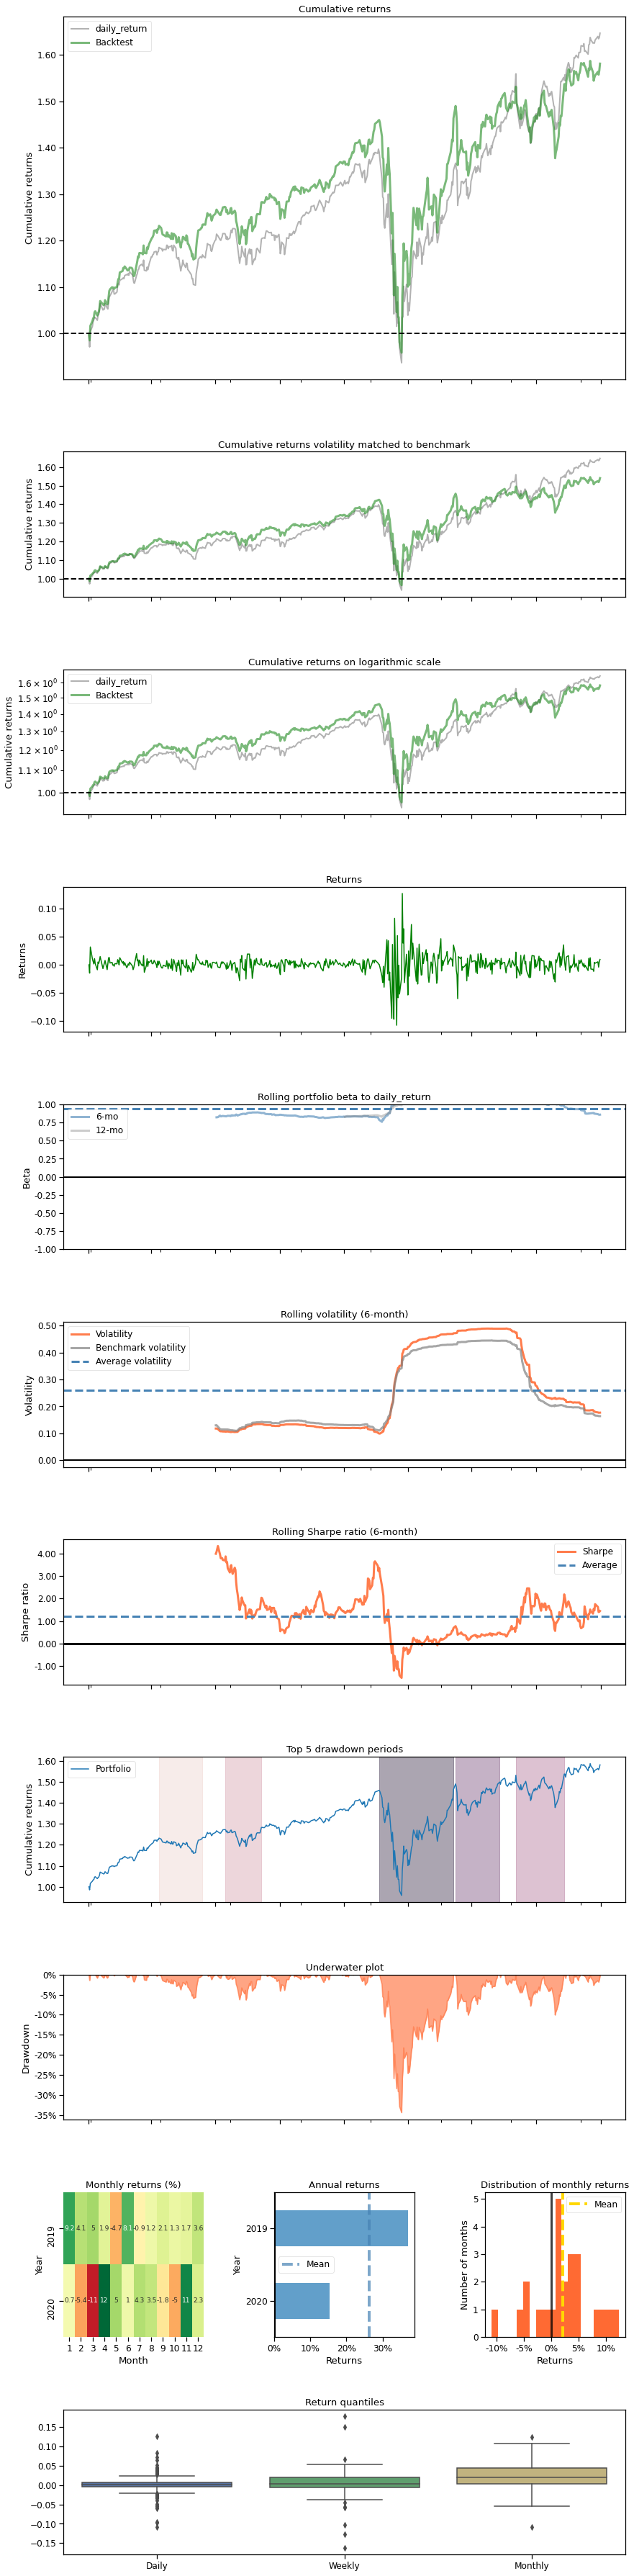

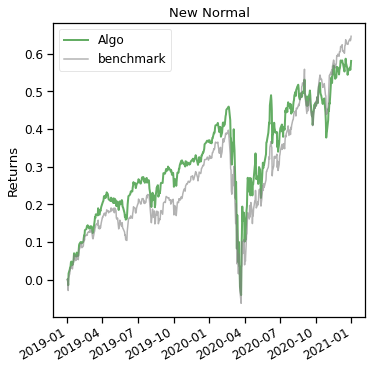

In [45]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [46]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:161430.51924071537
Sharpe:  1.014412517108271
hit end!


In [47]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.015978
2,2019-01-04,0.035393
3,2019-01-07,0.010182
4,2019-01-08,0.008490
...,...,...
500,2020-12-24,0.001665
501,2020-12-28,0.005959
502,2020-12-29,-0.003439
503,2020-12-30,0.004755


In [48]:
df_actions

,ADP,AXP,BEN,CCI,CMCSA,CPB,GILD,HES,KMB,KSU,LH,LIN,MMM,NEM,NVDA,PLD,RCL,SRE,TJX,XEL
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2019-01-03,0.028178,0.067011,0.067797,0.030079,0.025451,0.064317,0.056970,0.026532,0.065494,0.067348,0.067415,0.067036,0.026889,0.026548,0.058461,0.026215,0.065871,0.068032,0.062720,0.031637
2019-01-04,0.030869,0.069592,0.066493,0.027717,0.026777,0.037604,0.046084,0.026856,0.070424,0.070424,0.071578,0.070946,0.035745,0.027661,0.070965,0.026657,0.057716,0.066743,0.070986,0.028162
2019-01-07,0.029272,0.061041,0.060465,0.050464,0.023720,0.029908,0.058224,0.024352,0.059767,0.063467,0.062417,0.062457,0.058848,0.023751,0.062350,0.023766,0.060469,0.061265,0.060758,0.063239
2019-01-08,0.058255,0.061226,0.060877,0.023142,0.026635,0.059117,0.053100,0.024594,0.061479,0.060380,0.061333,0.060425,0.060742,0.026890,0.057354,0.023221,0.056813,0.059825,0.055161,0.049430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.060834,0.066275,0.063631,0.025620,0.024927,0.060931,0.040815,0.026044,0.066214,0.066489,0.066628,0.057562,0.028328,0.026282,0.060494,0.025241,0.064899,0.065790,0.065667,0.037328
2020-12-28,0.037004,0.064378,0.059944,0.028321,0.025522,0.052321,0.047595,0.024247,0.064499,0.064237,0.064895,0.064894,0.038168,0.024781,0.064122,0.024372,0.060329,0.064909,0.060239,0.065224
2020-12-29,0.037466,0.057782,0.065226,0.027066,0.025547,0.047136,0.062512,0.025595,0.067265,0.067386,0.067456,0.066678,0.029309,0.025524,0.067305,0.025380,0.067228,0.066025,0.066645,0.035468


In [49]:
df_actions.to_csv('df_actions_sac_2.csv')

In [50]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [51]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.269951
Cumulative returns      0.614305
Annual volatility       0.272393
Sharpe ratio            1.014413
Calmar ratio            0.768368
Stability               0.646425
Max drawdown           -0.351330
Omega ratio             1.241286
Sortino ratio           1.433529
Skew                   -0.368784
Kurtosis               13.261054
Tail ratio              0.905416
Daily value at risk    -0.033222
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,26.995%
Cumulative returns,61.431%
Annual volatility,27.239%
Sharpe ratio,1.01
Calmar ratio,0.77
Stability,0.65
Max drawdown,-35.133%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.13,2020-02-19,2020-03-23,2020-06-08,79
1,10.19,2020-06-08,2020-06-26,2020-08-06,44
2,8.55,2020-10-12,2020-10-28,2020-11-09,21
3,7.94,2020-09-02,2020-09-23,2020-10-09,28
4,5.94,2019-07-24,2019-08-14,2019-09-11,36


Stress Events,mean,min,max
New Normal,0.11%,-10.77%,11.76%


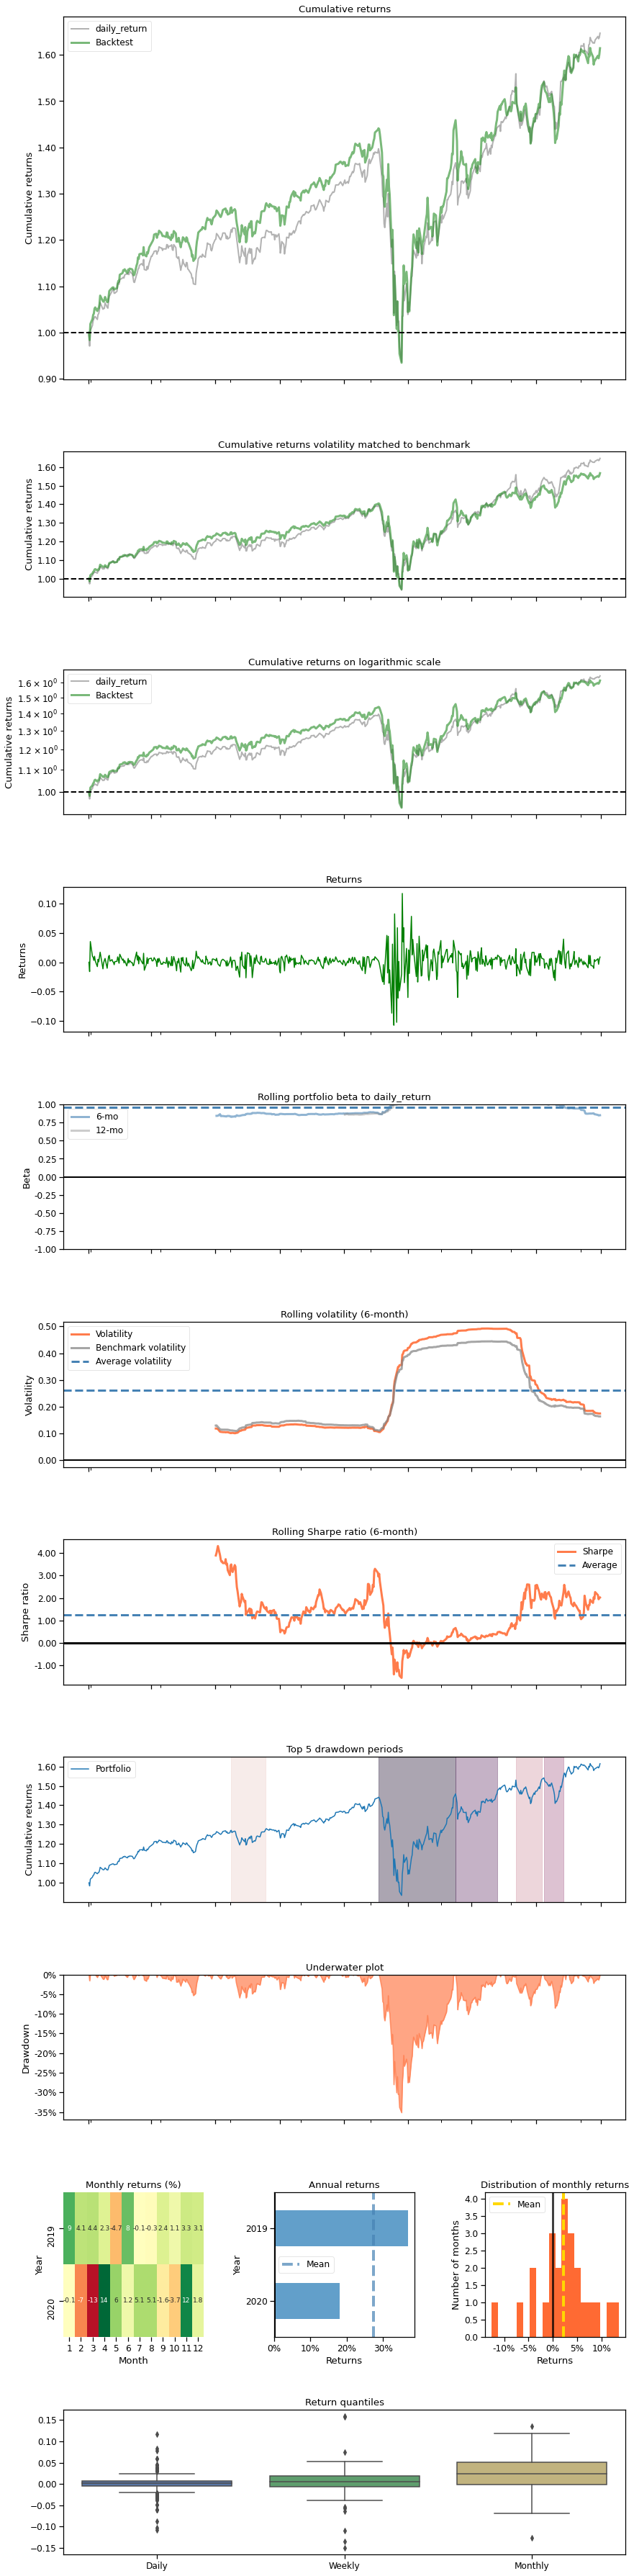

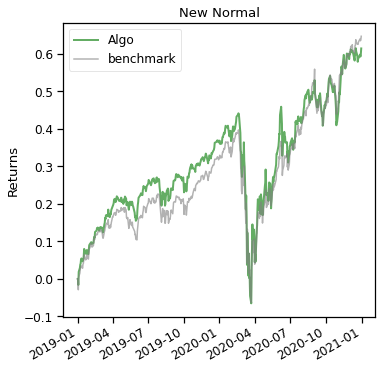

In [52]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)